In [1]:
import pickle
import pprint
from datetime import datetime
from pathlib import Path

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pytz
import seaborn as sns
from omegaconf import OmegaConf
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from src.config import cfg
from src.dir import create_dir
from src.seed import seed_everything

cfg.exp_number = Path().resolve().name
print(OmegaConf.to_yaml(cfg, resolve=True))

seed_everything(cfg.seed)


exp_number: '001'
run_time: base
data:
  input_root: ../../data/input
  train_path: ../../data/input/train_demo.csv
  test_path: ../../data/input/test_demo.csv
  sample_submission_path: ../../data/input/sample_submission.csv
  output_root: ../../data/output
  results_root: ../../results
  results_path: ../../results/001/base
seed: 319
n_splits: 5
target: target
lgb:
  params:
    objective: regression
    metric: rmse
    verbosity: -1
    boosting_type: gbdt
    learning_rate: 0.01
    num_leaves: 31
    min_child_samples: 20
    max_depth: -1
    subsample_freq: 0
    bagging_seed: 0
    feature_fraction: 0.9
    bagging_fraction: 0.9
    reg_alpha: 0.1
    reg_lambda: 0.1
  early_stopping_rounds: 100
  log_evaluation_period: 100
  num_boost_round: 100000



### データの読み込み

In [2]:
# データの読み込み
train_df = pl.read_csv(cfg.data.train_path, try_parse_dates=True)
test_df = pl.read_csv(cfg.data.test_path, try_parse_dates=True)
sample_submission_df = pl.read_csv(cfg.data.sample_submission_path, try_parse_dates=True)

# データの結合
train_test_df = pl.concat([train_df, test_df], how="diagonal")

# CV
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)


### 特徴量加工

In [3]:
# ラベルエンコーディング
le = LabelEncoder()
train_test_df = train_test_df.with_columns(
    pl.Series(le.fit_transform(train_test_df["category1"].fill_null(""))).alias("category1")
)

# 集約特徴量
train_test_df = train_test_df.with_columns(
    pl.col("feature1").mean().over("category1").alias("feature1_mean_by_category1")
)
train_test_df.head()


id,category1,feature1,feature2,target,feature1_mean_by_category1
i64,i64,f64,f64,i64,f64
1,0,0.451895,0.654711,5,0.485833
2,1,0.965642,0.008199,5,0.490346
3,1,0.793811,0.923839,2,0.490346
4,2,0.464083,0.069733,8,0.490287
5,1,0.022945,0.90639,4,0.490346


In [4]:
# train_test_dfをtrainとtestに分割
train_df = train_test_df.filter(pl.col(cfg.target).is_not_null())
test_df = train_test_df.filter(pl.col(cfg.target).is_null()).drop(cfg.target)


### 学習

In [5]:
x_train = train_df.drop([cfg.target]).to_pandas()
y_train = train_df[cfg.target].to_pandas()

# 実験結果格納用のディレクトリを作成
japan_tz = pytz.timezone("Asia/Tokyo")
cfg.run_time = datetime.now(japan_tz).strftime("%Y%m%d_%H%M%S")
create_dir(cfg.data.results_path)

# 学習設定
lgb_data = lgb.Dataset(
    x_train,
    label=y_train,
    # categorical_feature=cfg.categorical_features,
)
callbacks = [
    lgb.early_stopping(stopping_rounds=cfg.lgb.early_stopping_rounds),
    lgb.log_evaluation(cfg.lgb.log_evaluation_period),
]

# 学習
cv_results = lgb.cv(
    dict(cfg.lgb.params),
    lgb_data,
    folds=skf.split(x_train, y_train),
    num_boost_round=cfg.lgb.num_boost_round,
    callbacks=callbacks,
    return_cvbooster=True,
    seed=cfg.seed,
)

# 学習モデル保存
cvbooster = cv_results["cvbooster"]
with open(f"{cfg.data.results_path}/model.pkl", "wb") as f:
    pickle.dump(cvbooster, f)

# # モデルのロード
# with open(f"{cfg.data.results_path}/model.pkl", "rb") as f:
#     loaded_cvbooster = pickle.load(f)


Directory created: ../../results/001/20240923_123453
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid rmse: 2.83606 + 0.0272595
Early stopping, best iteration is:
[18]	cv_agg's valid rmse: 2.80286 + 0.0148947


### log


In [6]:
best_iteration = cvbooster.best_iteration
best_score = cv_results["valid rmse-mean"][best_iteration - 1]
best_score_stdv = cv_results["valid rmse-stdv"][best_iteration - 1]

with open(f"{cfg.data.results_path}/log.txt", "w") as log_file:
    log_file.write("====== CV Score ======\n")
    log_file.write(f"best_iteration: {best_iteration}\n")
    log_file.write(f"best_score: {best_score}\n")
    log_file.write(f"best_score_stdv: {best_score_stdv}\n")

    log_file.write("\n====== params ======\n")
    log_file.write(OmegaConf.to_yaml(cfg, resolve=True))

    log_file.write("\n====== feature name ======\n")
    log_file.write(pprint.pformat(cvbooster.feature_name()[0]))


### Feature Importance

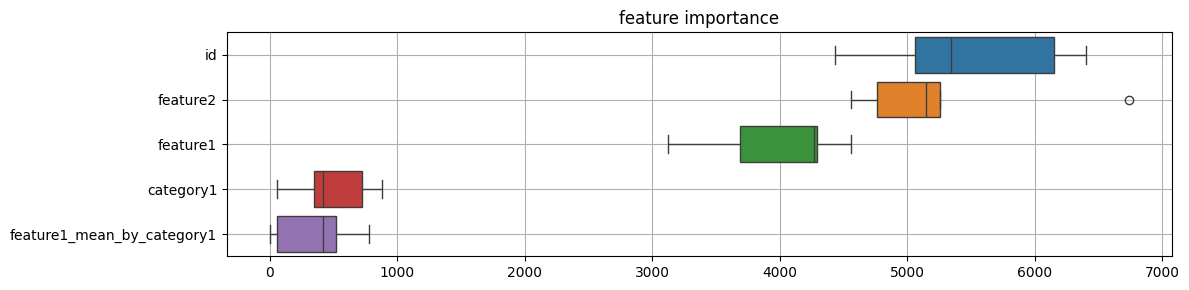

In [7]:
# 学習済みモデルから特徴量の重要度を取り出す
raw_importances = cvbooster.feature_importance(importance_type="gain")
importance_df = pd.DataFrame(data=raw_importances, columns=cvbooster.feature_name()[0])

# 平均値でソートする
sorted_indices = importance_df.mean(axis=0).sort_values(ascending=False).index
sorted_importance_df = importance_df.loc[:, sorted_indices]

# 上位をプロット -> 保存
plot_cols = sorted_importance_df.columns[:50]
fig, ax = plt.subplots(figsize=(12, max(3, len(plot_cols) * 0.15)))
sns.boxplot(data=sorted_importance_df[plot_cols], orient="h", ax=ax)
ax.grid()
ax.set_title("feature importance")
fig.tight_layout()
plt.show()
fig.savefig(f"{cfg.data.results_path}/feature_importance.png")


### oof

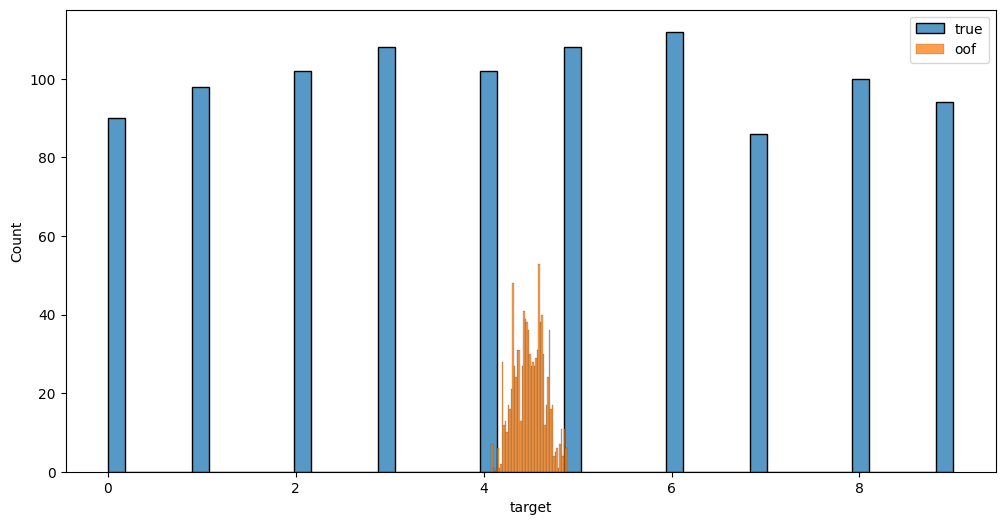

In [8]:
oof = np.zeros(len(train_df))

# 各foldで推論してoofを作成
for i, (_, val_idx) in enumerate(skf.split(x_train, y_train)):
    x_val = x_train.iloc[val_idx]
    model = cvbooster.boosters[i]
    oof[val_idx] = model.predict(x_val, num_iteration=cvbooster.best_iteration)

# oofを保存
np.save(f"{cfg.data.results_path}/oof.npy", oof)

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(y_train, bins=50, ax=ax)
sns.histplot(oof, bins=50, ax=ax)
plt.legend(["true", "oof"])
plt.show()
fig.savefig(f"{cfg.data.results_path}/oof_hist.png")


### Submission

In [9]:
# 推論
x_test = test_df.to_pandas()
y_preds = cvbooster.predict(x_test, num_iteration=cvbooster.best_iteration)
y_pred = np.mean(y_preds, axis=0)

# 提出ファイル作成
sub_df = pl.read_csv(cfg.data.sample_submission_path)
sub_df = sub_df.with_columns(pl.Series(y_pred).alias(cfg.target))
sub_df.write_csv(f"{cfg.data.results_path}/submission.csv")
sub_df.head()


id,target
i64,f64
1,4.592221
2,4.631716
3,4.692771
4,4.486453
5,4.676029
